## Задача 2. PageRank

1. Опишите алгоритм PageRank (введите все необходимые обозначения)
2. Как связаны задачи нахождения PageRank'а и поиска максимального собственноо вектора и соответствующего ему собственного значения и почему?
3. Реализуйте степенной метод нахождения максимального собственного вектора
4. Найдите с помощью степенного метода TOP-10 статей по величине PageRank'a по физике высоких энергий в соответствии с [графом](https://snap.stanford.edu/data/cit-HepTh.html). Результат должен быть воспроизводим, используйте разреженные матрицы для работы с матрицей смежности графа
5. Сравните теоретическую и экспериментальную сходимость степенного метода для этого графа. Нарисуйте график и объясните, почему он выглядит именно так?

## Описание алгоритма PageRank


PageRank — это числовая величина, характеризующая «важность» веб-страницы. Чем больше ссылок на страницу, тем она «важнее». Кроме того, «вес» страницы А определяется весом ссылки, передаваемой страницей B. Таким образом, PageRank — это метод вычисления веса страницы путём подсчёта важности ссылок на неё.

Формула, для вычисления PageRank, представленная в основополагающей статье Сергея Брина и Ларри Пейджа (отнормированная так, чтобы сумма всeх PageRank была равна единице)
$$ PR(p_i) = \frac{(1 - d)}{N} + d \sum_{p_j \in M(p_i)} \frac{PR(p_j)}{M(p_j)} $$

* $d$ — так называемый демпфирующий коэффициент, отображающий «количество авторитетности», передаваемое страницей-донором (источником ссылки) странице-акцептору (для которой рассчитывается PR). Величина коэффициента засекречена поисковиком, но наблюдения показывают, что с определенной точностью ее можно принять равной 0,85 (то есть 85% передаваемой авторитетности). По другим сведениям, демпфирующий коэффициент показывает вероятность перехода с донорской страницы на акцептор по установленной ссылке. Несмотря на отличие определений, d в этом случае также считают равным 0,85.
* $ p_1 \dots p_n $ — рассматриваемые страницы 
* $M(p_i)$ — страницы, ссылающиеся на $p_i$
* $L(p_i)$ — общее количество внешних ссылок, установленных на $i$-ой странице.
* $N$ — общее количество страниц

Значения PageRank'а составляют правый собственный вектор модифицированной матрицы смежности для графа

$ \begin{align}
    R &= \begin{bmatrix}
           PR(p_1) \\
           PR(p_2) \\
           \vdots \\
           PR(p_N)
         \end{bmatrix}
  \end{align} $

$ \begin{align}
    R &= \begin{bmatrix}
           (1 - d)/N \\
           (1 - d)/N \\
           \vdots \\
           (1 - d)/N
         \end{bmatrix}
  \end{align}  
  + d \begin{bmatrix}
      l(p_1, p_1) & l(p_1, p_2) & \dots & l(p_1, p_N) \\
      l(p_2, p_1) & \ddots & & \vdots \\
      \vdots &  & l(p_i, p_j) & \\
      l(p_N, p_1) & \dots & & l(p_N, p_N) \\
      \end{bmatrix} R
$

где $l(p_i, p_j) = 0$ если $p_j$ не ссылается на $p_i$, и отнормирована таким образом, что $\sum_{i=1}^{N} l(p_i, p_j) = 1 $

In [1]:
import numpy as np
import scipy.sparse as spsp
import scipy.sparse.linalg as splinalg

from scipy import linalg
from scipy.linalg import norm

def generateLowRankMatrix(size, rank):
    matrix = np.zeros((size, size))
    for i in range(rank):
        a = np.random.rand(size, 1)
        b = np.random.rand(1, size)
        matrix = matrix + a.dot(b)
    return matrix

In [2]:
class SolverSettings:
    def __init__(self, eps, maxiter):
        self.eps = eps
        self.maxiter = maxiter

class PowerMethodSolver:
    def __init__(self, settings):
        self.settings = settings
        
    def solve(self, A, y0):
        x = y0 / norm(y0, 2)
        err = 1.0
        points = []
        iterationPoints = []
        errorPoints = []
        currentIteration = 0
        while err > self.settings.eps and currentIteration < self.settings.maxiter:
            y = A.dot(x)
            # xPrev = x
            x = y / norm(y, 2)
            l = x.T.dot(A.dot(x))
            #l = norm(x, 2) / norm(xPrev, 2)
            points.append(l)
            if currentIteration > 0:
                err = norm(A.dot(x) - l * x, 2)
                #err = abs(points[currentIteration] - points[currentIteration - 1])
                
            errorPoints.append(err)
            iterationPoints.append(currentIteration)
            currentIteration += 1
        
        self.points = points
        self.iterations = currentIteration
        self.iterationPoints = iterationPoints
        self.errorPoints = errorPoints
    
    def getLambdaPoints(self):
        return self.points
    
    def getIterations(self):
        return self.iterations
    
    def getIterationPoints(self):
        return self.iterationPoints
    
    def getErrorPoints(self):
        return self.errorPoints

In [3]:
settings = SolverSettings(1e-10, 1000)
solver = PowerMethodSolver(settings)

In [4]:
size = 100
rank = 10
randomMatrix = generateLowRankMatrix(size, rank)
randomVector = np.random.rand(size)

In [5]:
solver.solve(randomMatrix, randomVector)

### Реализация степенного метода и нахождение максимального собственного значения для случайно сгенерированной матрицы размера $size$ и ранга $rank$

Было проведено сравнение найденного собственного значения собственной реализации степенного метода и библиотечной функции

Found lambda: 257.478192289
Real lambda: (257.478192289+0j)


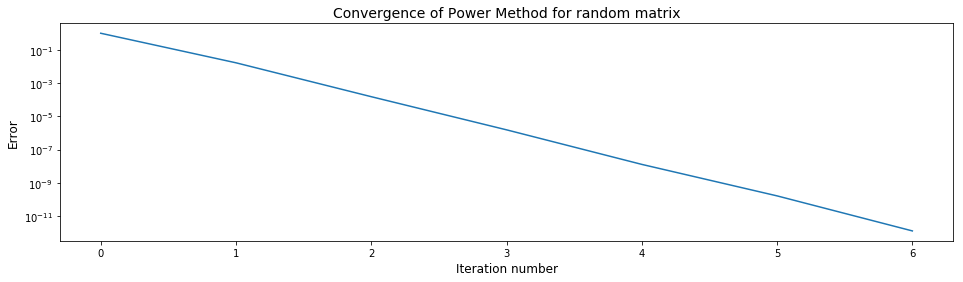

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
plt.plot(solver.getIterationPoints(), solver.getErrorPoints())
plt.title("Convergence of Power Method for random matrix", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("Error", fontsize=12)
_ = plt.yscale("log")

# plt.figure(figsize=(16, 4))
# plt.plot(solver.getIterationPoints(), solver.getLambdaPoints())
# plt.title("Lambda value", fontsize=14)
# plt.xlabel("Iteration number", fontsize=12)
# _ = plt.ylabel("Lambda", fontsize=12)

print("Found lambda: " + str(solver.getLambdaPoints()[solver.getIterations() - 1]))
print("Real lambda: " + str(np.linalg.eig(randomMatrix)[0][0]))

Считывание файла и генерация sparse-матрицы смежности

In [7]:
class AdjacencyMatrix:
    def __init__(self, fileName):
        self.generateFromFile(fileName)
        
    def getMatrix(self):
        return self.matrix
    
    def getNNZ(self):
        return self.nnz
    
    def getLinksCount(self):
        return self.linksCount
    
    def getGraph(self):
        return self.graph
    
    def getLinkMap(self):
        return self.linkMap
    
    def generateFromFile(self, fileName):
        k = 0
        graph = {}
        linkMap = {}
        with open(fileName) as f:
            for line in f:
                if line.startswith("#"):
                    continue
                
                linking = line.split()
                linkFrom = int(linking[0])
                linkTo = int(linking[1])
                # print(linkFrom, linkTo)
                
                if linkMap.get(linkFrom) == None:
                    linkMap[linkFrom] = k
                    k += 1
                
                if linkMap.get(linkTo) == None:
                    linkMap[linkTo] = k
                    k += 1
                
                if graph.get(linkFrom) == None:
                    graph[linkFrom] = [linkTo]
                else:
                    arr = graph.get(linkFrom)
                    arr.append(linkTo)
                    graph[linkFrom] = arr

        self.linksCount = len(linkMap.values())
        matrix = spsp.lil_matrix((self.linksCount, self.linksCount))

        for linkFrom in graph.keys():
            linksTo = graph[linkFrom]
            linksOut = len(linksTo)
    
            for link in linksTo:
                # if j->i then Aij = 1
                matrix[linkMap[link], linkMap[linkFrom]] = (1.0 / linksOut)

        self.matrix =  matrix.tocsr()
        self.nnz = matrix.nnz
        self.linkMap = linkMap
        self.graph = graph

Модифицированный степенной метод для решения задачи нахождения PageRank

In [8]:
class SparseGooglePowerMethodSolver:
    def __init__(self, settings):
        self.settings = settings
        
    def solve(self, M, d, y0, saveXVectors = False):
        x = y0 / norm(y0, 2)
        if saveXVectors:
            self.xVectors = [x]
        err = 1.0
        points = []
        iterationPoints = []
        errorPoints = []
        currentIteration = 0
        entity = np.ones((matrix.getLinksCount(), 1))
        while err > self.settings.eps and currentIteration < self.settings.maxiter:
            y = d * M.getMatrix().dot(x) + ((1.0 - d) / M.getLinksCount()) * entity.dot((entity.T.dot(x)))
            x = y / norm(y, 2)
            l = x.T.dot(M.getMatrix().dot(x))[0]
            points.append(l)
            if currentIteration > 0:
                err = norm(M.getMatrix().dot(x) - l * x, 2)
                #err = abs(points[currentIteration] - points[currentIteration - 1])
                
            errorPoints.append(err)
            iterationPoints.append(currentIteration)
            currentIteration += 1
            
            if saveXVectors:
                self.xVectors.append(x)
        
        self.points = points
        self.iterations = currentIteration
        self.iterationPoints = iterationPoints
        self.errorPoints = errorPoints
        self.x = x
    
    def getLambdaPoints(self):
        return self.points
    
    def getIterations(self):
        return self.iterations
    
    def getIterationPoints(self):
        return self.iterationPoints
    
    def getErrorPoints(self):
        return self.errorPoints
    
    def getX(self):
        return self.x
    
    def getXVectors(self):
        return self.xVectors

In [9]:
matrix = AdjacencyMatrix('data/Cit-HepTh.txt')
print("NNZ: " + str(matrix.getNNZ()))
print("Links count: " + str(matrix.getLinksCount()))

NNZ: 352807
Links count: 27770


Решение задачи нахождения PageRank'а с помощью степенного метода, реализованного в классе SparseGooglePowerMethodSolver для двух случаев, отличающихся только начальным приближением $v_0$

Демпфирующий коэффициент $d$ в данном случае был выбран равным 0.95

Метод достаточно точно находит собственное значение равное единице и собственный вектор

Found lambda: 1.00096944516
Found lambda: 1.0009682764


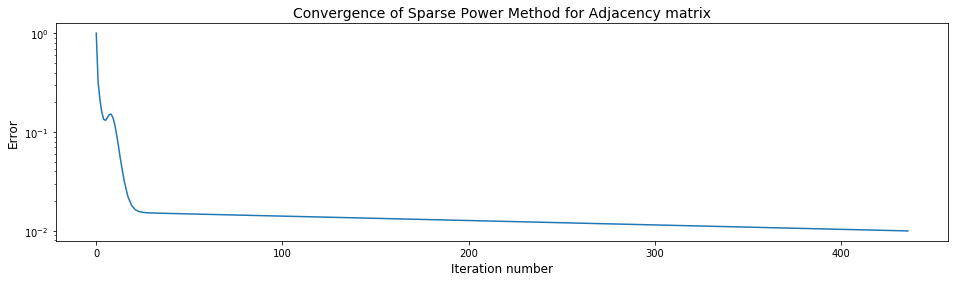

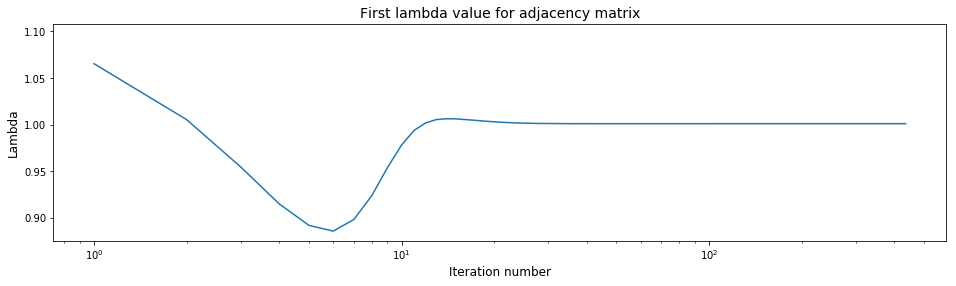

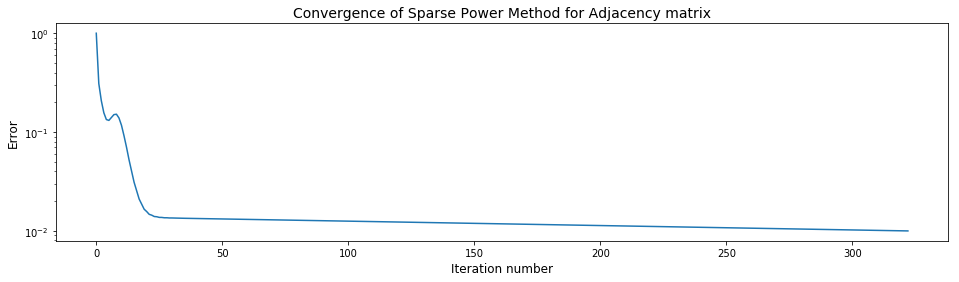

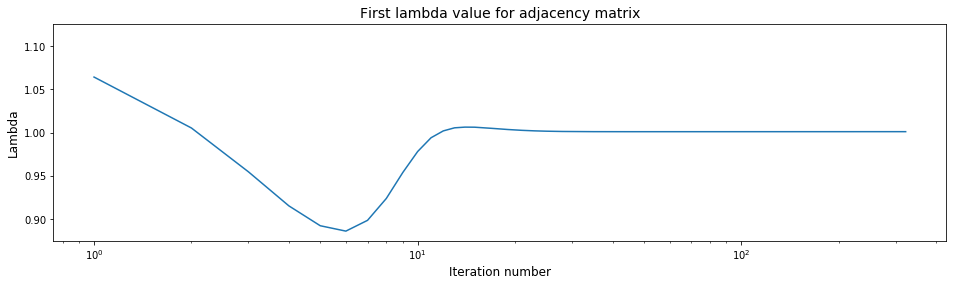

In [10]:
import scipy.sparse.linalg as sparselinalg

settings = SolverSettings(1e-2, 1000)
gSolver = SparseGooglePowerMethodSolver(settings)

v0 = np.abs(np.random.randn(matrix.getLinksCount()).reshape(matrix.getLinksCount(), 1))
gSolver.solve(matrix, 0.95, v0)

plt.figure(figsize=(16, 4))
plt.plot(gSolver.getIterationPoints(), gSolver.getErrorPoints())
plt.title("Convergence of Sparse Power Method for Adjacency matrix", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("Error", fontsize=12)
_ = plt.yscale("log")

plt.figure(figsize=(16, 4))
plt.plot(gSolver.getIterationPoints(), gSolver.getLambdaPoints())
plt.title("First lambda value for adjacency matrix", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.xscale("log")
_ = plt.ylabel("Lambda", fontsize=12)

print("Found lambda: " + str(gSolver.getLambdaPoints()[gSolver.getIterations() - 1][0]))

v0 = np.ones((matrix.getLinksCount(), 1))
gSolver.solve(matrix, 0.95, v0)

plt.figure(figsize=(16, 4))
plt.plot(gSolver.getIterationPoints(), gSolver.getErrorPoints())
plt.title("Convergence of Sparse Power Method for Adjacency matrix", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("Error", fontsize=12)
_ = plt.yscale("log")

plt.figure(figsize=(16, 4))
plt.plot(gSolver.getIterationPoints(), gSolver.getLambdaPoints())
plt.title("First lambda value for adjacency matrix", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.xscale("log")
_ = plt.ylabel("Lambda", fontsize=12)

print("Found lambda: " + str(gSolver.getLambdaPoints()[gSolver.getIterations() - 1][0]))

### Вывод топ-10 статей отранжированных по метрике PageRank 

In [11]:
# Top 10
ranks = gSolver.getX()
ranks = (ranks / norm(ranks, 1)) * matrix.getLinksCount()

sortedRanks = np.argsort(ranks[:,0])
topRanks = sortedRanks[-10:][::-1]
linkMap = matrix.getLinkMap()
index = 1
print("Top 10 by page rank")
for i in topRanks:
    linkID = list(linkMap.keys())[list(linkMap.values()).index(i)]
    print(index, "Rank: ", ranks[i, 0], "Link ID: ", linkID)
    index += 1

Top 10 by page rank
(1, 'Rank: ', 9922.4328731727892, 'Link ID: ', 9207016)
(2, 'Rank: ', 9832.6539298391181, 'Link ID: ', 9201015)
(3, 'Rank: ', 195.37539516530191, 'Link ID: ', 9307086)
(4, 'Rank: ', 175.19046779972959, 'Link ID: ', 6187)
(5, 'Rank: ', 170.58217846452584, 'Link ID: ', 9404069)
(6, 'Rank: ', 155.20380288476818, 'Link ID: ', 9206056)
(7, 'Rank: ', 116.84200170090473, 'Link ID: ', 9308150)
(8, 'Rank: ', 114.2853466447291, 'Link ID: ', 9301082)
(9, 'Rank: ', 84.373672400910692, 'Link ID: ', 9308141)
(10, 'Rank: ', 56.87988193327547, 'Link ID: ', 9407087)


### Сравнение теоретической и экспериментальной сходимости

Процесс нахождения максимального собственного значения с помощью степенного метода должен сходиться линейно со знаменателем $|\frac{\lambda_2}{\lambda_1}|$

Проверим экспериментальную сходимость степенного метода для этого графа и сравним ее с теоретической

In [37]:
lambdas, vectors = sparselinalg.eigs(matrix.getMatrix(), k = 2)
lambda1, lambda2 = lambdas[0], lambdas[1]

convergencyCoefficient = abs(lambda2 / lambda1)
print("Lambda1: ", lambda1.real, "Lambda2: ", lambda2.real)
print("Convergence coefficient: ", convergencyCoefficient)

('Lambda1: ', -1.0000000000000002, 'Lambda2: ', -0.99999999999999967)
('Convergence coefficient: ', 0.99999999999999944)


In [17]:
x0 = np.ones((matrix.getLinksCount(), 1))

settings = SolverSettings(eps = 10e-10, maxiter=1000)
gSolver = SparseGooglePowerMethodSolver(settings)
gSolver.solve(matrix, 0.95, x0, saveXVectors=True)

In [18]:
x0 = map(lambda x: x[0].real, x0)
x = map(lambda x: x[0].real, vectors)
#coefs = map(lambda xk: norm(xk - x, 2) / norm(x0 - x, 2), gSolver.getXVectors())

In [19]:
import math
def substractNorm(x, y):
    r = 0.0
    for i in range(len(x)):
        r += (x[i] - y[i]) ** 2
    return math.sqrt(r)

def getKConvergenceCoefficient((i, xk)):
    xkm = map(lambda xk: xk[0].real, xk)
    return (substractNorm(xkm, x) / substractNorm(x0, x)) ** (1.0 / max(i, 1))

coefs = map(getKConvergenceCoefficient, list(enumerate(gSolver.getXVectors())))

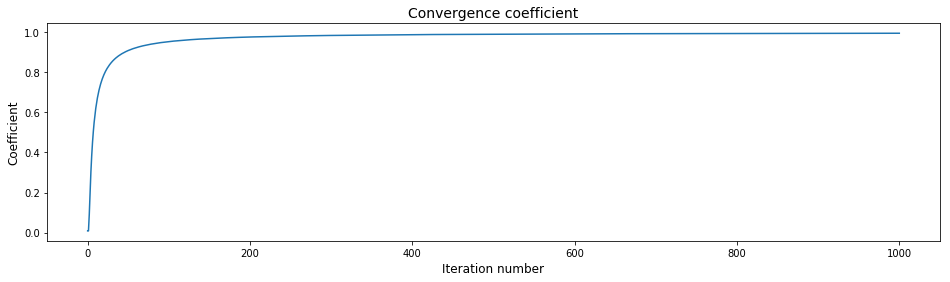

In [32]:
plt.figure(figsize=(16, 4))
plt.plot(coefs)
plt.title("Convergence coefficient", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
_ = plt.ylabel("Coefficient", fontsize=12)
#plt.yscale("log")
#_ = plt.xscale("log")

Про сходимость степенного метода - если наибольшее собственное значение кратное, но соответсвующий элементарный делитель матрицы линеен, то итерации сходятся обычным образом. Но если $\lambda_1 \neq \lambda_2$, а их модули равны или если элементарный делитель матрицы нелинеен (жорданова клетка), то процесс не будет сходиться.

Если $|\lambda_1| \approx |\lambda_2|$, то сходимость очень медленная 